# Activity: Dijkstra's Shortest Path Algorithm
In this activity, you will play around with an implementation of Dijkstra's Shortest Path algorithm for finding shortest paths from a single source to all other vertices in a weighted graph. The time complexity of Dijkstra's algorithm is $\mathcal{O}((|\mathcal{V}| + |\mathcal{E}|)\cdot\log|\mathcal{V}|)$, where $|\mathcal{E}|$ is the number of edges and $|\mathcal{V}|$ is the number of vertices in the graph (where we use a priority queue to keep track of nodes to explore).

> __Problem overview:__ Suppose we are planning a multistep task that must be completed for a complex project, e.g., constructing a new production process. At our planning meeting, we brainstorm two different ideas about how to accomplish the overall task, one idea involves only five steps, but has a few costly steps. The second idea involves six steps, and several of the steps are less expensive. Which idea (path) should we choose? 

This is a classic shortest path problem! We'll build a small example, run the algorithm, and visualize the resulting paths so you can see how the shortest path is determined.
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

In [1]:
include(joinpath(@__DIR__, "Include.jl"));

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl), check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material. 

### Why Dijkstra?
Before diving into the implementation, let's understand why we're using Dijkstra's algorithm for this particular problem.

> __Handling non-negative weights:__ Dijkstra's algorithm is designed for graphs with __non-negative edge weights__, which is perfect for our project planning scenario where all costs are positive (time, money, resources). This assumption allows Dijkstra to use a greedy approach that's more efficient than general shortest path algorithms.

> __Algorithm efficiency:__ Dijkstra has time complexity $\mathcal{O}((|\mathcal{V}|+|\mathcal{E}|)\log|\mathcal{V}|)$ with a priority queue, which is faster than Bellman-Ford's $\mathcal{O}(|\mathcal{V}|\cdot|\mathcal{E}|)$ when edge weights are non-negative. This efficiency makes it ideal for large-scale routing and planning problems.

> __Greedy optimization:__ Dijkstra uses a __greedy strategy__ - it always expands the closest unvisited node first. This works because with non-negative weights, the shortest path to any node can't be improved by going through a more distant node first.

> __When Dijkstra fails:__ If our graph contained negative edge weights (e.g., rebates, cost savings), Dijkstra would fail because its greedy assumptions break down. In such cases, we'd need Bellman-Ford or other algorithms that can handle negative weights.

__Real-world applications:__ Dijkstra's algorithm forms the foundation for GPS navigation systems (which use enhanced versions like A*), network routing protocols, logistics optimization, and any scenario where you need to find minimum cost paths with positive costs.

### Constants
Let's define some constants that will be used throughout the notebook. See the comment for a description of each constant, what it represents, its value, units, etc.

In [2]:
# We are going to plot the path through a graph, so let's provide the coordinates for each node, i.e., the layout
# This layout looks like our schematic but you can rearrange this if you want!
node_coordinates = [

    # source node (project start)
    10.0 10.0 ; # 1 source node s (x,y) coordinates
    11.0 10.0 ; # 2 
    11.0 11.0 ; # 3
    13.0 11.0 ; # 4
    13.0 10.0 ; # 5
    11.0 9.0  ; # 6 
    12.0 9.0  ; # 7
    13.0 9.0  ; # 8
    14.0 10.0  ; # 9 project completion
];

### Implementations
Below are helper routines used in this notebook. The `reconstruct_path(...)` function reconstructs the shortest path from the predecessor map returned by Dijkstra's algorithm.

We'll also provide a few small utility functions (below) to parse the edge list and build the graph model. The code cells below include thorough docstrings and comments — skim the docstrings if you want the quick idea, or read the comments for implementation details.

In [3]:
"""
    function reconstruct_path(pmap, node)

Reconstructs the shortest path from the source to a given node using the predecessor map.

### Arguments
- `pmap`: A dictionary mapping each node to its predecessor in the shortest path tree.
- `node`: The target node for which to reconstruct the path.

### Returns
- An array representing the path from source to the target node.
"""
function reconstruct_path(pmap, node)
       
    path = Int[]
    cur = node
    while cur !== nothing
        push!(path, cur)
        cur = get(pmap, cur, nothing)
    end
    reverse!(path)
    return path
end;

## Task 1: Build a project task graph
In this task, we will build a simple directed graph representing the steps in a project, where each edge has a weight that represents the cost of completing that step. The graph will be represented as an adjacency list.

Edges are stored in `data/Production-Process.edgelist` with fields: source, target, cost. We'll parse the file into `MyGraphEdgeModel` instances and then build a directed graph model for the shortest path calculation using Dijkstra's algorithm.

<div>
    <center>
        <img src="figs/Fig-Branch-Schematic.svg" width="480"/>
    </center>
</div>

The graph and weights are specified in the `data/Production-Process.edgelist` file, where each record is defined as:
> __Records__: Each record in our edgelist file has the comma separated fields: `source,` `target,` `cost.` The `source` field is the id for the source node, e.g., `1`, the `target` field is the target node id, the `cost` is the cost of assigning the source node to the target node, i.e., the cost (monetary, time, etc.) of completing the task.

Ok, so now let's setup our edge parser __callback function__:

In [4]:
"""
    function edgerecordparser(record::String, delim::Char=',') -> Tuple{Int, Int, Float64} | Nothing

This method is called to parse a single edge record from the edgelist file. It gets called once for each record in the file. 
The function splits the record into fields based on the specified delimiter and extracts the source node, target node, and cost (weight) of the edge. 
It returns a tuple containing these values. If the record does not have the expected number of fields, it returns `nothing`.

### Arguments
- `record`: The edge record string to parse.
- `delim`: The delimiter used to split the record.

### Returns
- A tuple containing the source node, target node, and cost of the edge, or `nothing` if the record is invalid.
"""
function edgerecordparser(record::String, delim::Char=',')

    # record (three fields)
    # source, target, cost

    fields = split(record, delim) # this assumes a record of the form "source,target,weight"
    if length(fields) < 3 # we have 3 fields
        return nothing
    end

    # get my data -
    source = parse(Int, fields[1]) # source id
    target = parse(Int, fields[2]) # target id
    cost = parse(Float64, fields[3]) # edge weight
    
    # return a tuple -
    return (source, target, cost)
end;

Next, let's set the path to the edge list file in the `path_to_edge_file::String` variable:

In [5]:
path_to_edge_file = joinpath(_PATH_TO_DATA, "Production-Process.edgelist"); # this points to the graph shown above

Next, construct a dictionary [of `MyEdgeModel` instances](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyGraphEdgeModel) which stores the data for the edges. Let's save our edge models in the `myedgemodels::Dict{Int64, MyGraphEdgeModel}` dictionary. 

The keys in the edge dictionary will be the edge ids (which we can assume are unique), and the values will be the corresponding `MyGraphEdgeModel` instances. Here, we've used the line index in the edgefile as the edge id.

In [6]:
myedgemodels = MyGraphEdgeModels(path_to_edge_file, edgerecordparser, delim=',', comment='#')

Dict{Int64, MyGraphEdgeModel} with 9 entries:
  0 => MyGraphEdgeModel(0, 1, 2, 1.0)
  4 => MyGraphEdgeModel(4, 2, 6, 2.0)
  5 => MyGraphEdgeModel(5, 6, 7, 2.0)
  6 => MyGraphEdgeModel(6, 7, 8, 2.0)
  2 => MyGraphEdgeModel(2, 3, 4, 8.0)
  7 => MyGraphEdgeModel(7, 8, 5, 2.0)
  8 => MyGraphEdgeModel(8, 5, 9, 1.0)
  3 => MyGraphEdgeModel(3, 4, 5, 2.0)
  1 => MyGraphEdgeModel(1, 2, 3, 4.0)

Finally, we can build a graph instance. Since this is a directed graph, we'll construct [a `MySimpleDirectedGraphModel` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MySimpleDirectedGraphModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build). Let's save our graph model in the `directedgraphmodel::MySimpleDirectedGraphModel` variable.

In [7]:
directedgraphmodel = build(MySimpleDirectedGraphModel, myedgemodels);

__Hmmm__. What's in [a `MySimpleDirectedGraphModel` object](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MySimpleDirectedGraphModel)? We can always answer these types of questions by examining the fields of the object Type [using the `typeof(...)` function](https://docs.julialang.org/en/v1/base/base/#Core.typeof) in combination with [the `fieldnames(...)` function](https://docs.julialang.org/en/v1/base/base/#Base.fieldnames).

> __Why do we inspect the fields of a Type?__ We need to get the type of the instance we want to inspect because fields are associated with a type, not the instance itself. Thus, we always use `typeof(...)` to get the type, and then `fieldnames(...)` to get the fields of that type.

Ok, so what is contained in a directed graph model:

In [8]:
typeof(directedgraphmodel) |> T -> fieldnames(T) # We get the type T, then we get the field names of T

(:nodes, :edges, :children, :edgesinverse)

Let's look at the `edges::Dict{Tuple{Int,Int},Float64}` field of the `MySimpleDirectedGraphModel` object. This field stores the weights of the edges in the graph, where the keys are tuples representing the source and target nodes, and the values are the corresponding edge weights.

In [9]:
directedgraphmodel.edgesinverse

Dict{Int64, Tuple{Int64, Int64}} with 9 entries:
  5 => (4, 5)
  4 => (3, 4)
  6 => (5, 9)
  7 => (6, 7)
  2 => (2, 3)
  9 => (8, 5)
  8 => (7, 8)
  3 => (2, 6)
  1 => (1, 2)

In [10]:
directedgraphmodel.edges

Dict{Tuple{Int64, Int64}, Number} with 9 entries:
  (4, 5) => 2.0
  (1, 2) => 1.0
  (7, 8) => 2.0
  (6, 7) => 2.0
  (3, 4) => 8.0
  (8, 5) => 2.0
  (5, 9) => 1.0
  (2, 3) => 4.0
  (2, 6) => 2.0

## Task 2: Compute Shortest Paths
In this task, we'll compute the best (lowest cost) production planning paths.

This is a simple test case, so we can look at the edge weights and guess the shortest paths using intuition, without running the algorithm. Let's do that so we can check if what we think should happen, actually happens.

Let's look at the costs for each edge:

In [11]:
let

    # initialize -
    df = DataFrame(); 
    edges = directedgraphmodel.edges
    edgesinverse = directedgraphmodel.edgesinverse
    edge_id_vector = keys(edgesinverse) |> collect |> sort;

    # look at the edges -
    for i ∈ edge_id_vector

        (s,t) = edgesinverse[i] # get the source and target nodes for this edge

        row_df = (
            edge = i,
            s = s,
            t = t,
            w = edges[(s,t)]
        )
        push!(df, row_df);
    end

    pretty_table(df, tf = tf_simple);
end

======== ======= ======= ==========
   edge       s       t         w 
  Int64   Int64   Int64   Float64 
======== ======= ======= ==========
      1       1       2       1.0
      2       2       3       4.0
      3       2       6       2.0
      4       3       4       8.0
      5       4       5       2.0
      6       5       9       1.0
      7       6       7       2.0
      8       7       8       2.0
      9       8       5       2.0
======== ======= ======= ==========


The _top_ path has edges `(1, 2)`, `(2, 3)`, `(3, 4)`, `(4,5)` and `(5,9)`. On the other hand, the _bottom_ path has edges `(1, 2)`, `(2,6)`, `(6, 7)`, `(7, 8)`, `(8, 5)` and `(5, 9)`. Let's compute the cost of both paths—which is less expensive?

> __Intuition:__ In this simple graph with only two main paths from start to finish, we can manually compare the total costs. The path with the lower sum of edge weights should be the shortest path that Dijkstra finds. This gives us a prediction to verify against the algorithm results.

Let's check the costs:

In [12]:
let

    # initialize -
    top_path = ((1,2), (2,3), (3,4), (4,5), (5,9))
    bottom_path = ((1,2), (2,6), (6,7), (7,8), (8,5), (5,9))
    edges = directedgraphmodel.edges

    # compute costs for each path -
    top_cost = sum(edges[e] for e ∈ top_path)
    bottom_cost = sum(edges[e] for e ∈ bottom_path)

    # display the costs and make prediction -
    println("Top path cost: $(top_cost)")
    println("Bottom path cost: $(bottom_cost)")
    println("Difference: $(abs(top_cost - bottom_cost))")
    println()
    
    # compare costs -
    if top_cost < bottom_cost
        println("✓ Prediction: Top path is less expensive - Dijkstra should choose this path")
    else
        println("✓ Prediction: Bottom path is less expensive - Dijkstra should choose this path")
    end
end

Top path cost: 16.0
Bottom path cost: 10.0
Difference: 6.0

✓ Prediction: Bottom path is less expensive - Dijkstra should choose this path
Bottom path cost: 10.0
Difference: 6.0

✓ Prediction: Bottom path is less expensive - Dijkstra should choose this path


To compute shortest paths we [call the `findshortestpath(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/graphs/#VLDataScienceMachineLearningPackage.findshortestpath) with three main inputs: the graph model, the start node, and the algorithm choice (here `DijkstraAlgorithm()`).

The function returns a distances dictionary (`d`) mapping each node to its shortest distance from the start, and a predecessors dictionary (`p`) mapping each node to its predecessor on the shortest path.

We'll run Dijkstra on our graph and then visualize which edges lie on the shortest paths from the source.

In [13]:
(d,p) = let
    
    # initialize -
    startnode = directedgraphmodel.nodes[1];

    # run Dijkstra's algorithm -
    (d,p) = findshortestpath(directedgraphmodel, startnode, algorithm = DijkstraAlgorithm());

    (d,p) # return
end;

### Verification: Was our prediction correct?
Let's check if Dijkstra found the same shortest path that we predicted from our manual analysis.

> __What we're checking:__ We manually calculated the costs of the two main paths and predicted which one Dijkstra should choose. Now we'll reconstruct the actual shortest path and verify our intuition was correct.

> __Why verification matters:__ This builds confidence in both our understanding of the algorithm and our ability to manually analyze simple graphs. For more complex graphs, this intuitive approach becomes harder, but the principle remains the same.

In [14]:
let

    # initialize -
    target_node = 9;

    # Reconstruct the shortest path from node 1 to node 9 (project completion)
    expected_shortest_path = [1, 2, 6, 7, 8, 5, 9]; # this is the expected path based on the graph structure
    
    # Use the existing reconstruct_path function
    computed_shortest_path = reconstruct_path(p, target_node)
    
    # test -
    @test computed_shortest_path == expected_shortest_path
end

Test Passed

__Which path do we get?__ `Unhide` the code block below to see which edges are on the shortest path. Do we get what we think?

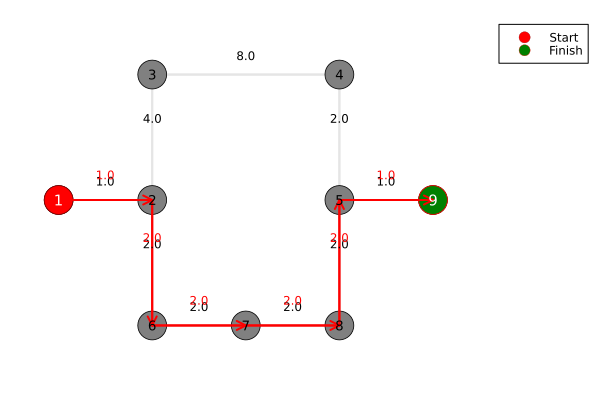

In [ ]:
let

    # initialize -
    base_graphmodel = directedgraphmodel;
    source_node = 1
    target_node = 9
    shortest_path_nodes = reconstruct_path(p,  target_node); # reconstruct the path to the project completion node (9)

    # build set of edges on the shortest path for quick lookup
    path_edges = length(shortest_path_nodes) > 1 ? Set((shortest_path_nodes[i], shortest_path_nodes[i+1]) for i in 1:length(shortest_path_nodes)-1) : Set{Tuple{Int,Int}}()

    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
        # annotate the edge weight slightly above the midpoint unless this edge is on the shortest path
        if !((s,t) in path_edges)
            mx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
            my = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
            w = round(base_graphmodel.edges[(s,t)], digits=2)
            annotate!(mx, my + 0.15, text(string(w), 8, :black))
        end
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:red, 
             label="Finish")

    # plot path -
    for i in 1:length(shortest_path_nodes)-1
        s = shortest_path_nodes[i]
        t = shortest_path_nodes[i+1]
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:red, lw=2, label="")
        # annotate the path-edge weight in red slightly above the red edge
        mwx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        mwy = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        w = round(base_graphmodel.edges[(s,t)], digits=2)
        annotate!(mwx, mwy + 0.20, text(string(w), 8, :red))
    end

    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(8.5, 11.5))

    current()
end

## Task 3: There was a sale on equipment!
In this task, we'll implement a scenario in which the expensive steps of the process in the top branch are discounted, affecting the overall cost and potentially the shortest path, e.g., we take advantage of a sale (or a donation) on the equipment that makes up a specific edge to discount, namely `(3, 4)` which corresponds to edge `4.`

Make a copy of the original graph model, and then update the edge weights to reflect the sale price of that step. We'll [use the `deepcopy(...)` method](https://docs.julialang.org/en/v1/base/base/#Base.deepcopy) to make a copy of the graph model, then we'll update the edge weights.

Save the copy of the graph model in the `discounted_graphmodel::MySimpleDirectedGraphModel` variable.

In [16]:
discounted_graphmodel = deepcopy(directedgraphmodel); # make a copy of the original graph model

The [`MySimpleDirectedGraphModel` type is mutable](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MySimpleDirectedGraphModel), and the edge weights are stored in the `edges::Dict{Tuple{Int,Int},Float64}` field (which is also mutable), so we can update the model.

In [17]:
discounted_graphmodel = let 

    # initialize -
    discount_factor = 0.0; # discount factor
    expensive_steps = [4]; # these are the steps that are discounted
    edgesinverse = discounted_graphmodel.edgesinverse; # get the inverse edge map

    for step ∈ expensive_steps
       
        # get the node tuple associated with this edge
        (s,t) = edgesinverse[step];
        
        # apply the discount factor to the edge weight
        discounted_graphmodel.edges[(s,t)] *= discount_factor;
    end
    discounted_graphmodel
end;

What are the new prices for the edges?

In [18]:
let

    # initialize -
    df = DataFrame(); 
    edges = directedgraphmodel.edges
    discounted_edges = discounted_graphmodel.edges
    edgesinverse = directedgraphmodel.edgesinverse
    edge_id_vector = keys(edgesinverse) |> collect |> sort;

    # look at the edges -
    for i ∈ edge_id_vector

        (s,t) = edgesinverse[i] # get the source and target nodes for this edge

        row_df = (
            edge = i,
            s = s,
            t = t,
            w = edges[(s,t)],
            w_discounted = discounted_edges[(s,t)],
            Δ =  discounted_edges[(s,t)] - edges[(s,t)]
        )
        push!(df, row_df);
    end

    pretty_table(df, tf = tf_simple);
end

======== ======= ======= ========= ============== ==========
   edge       s       t         w   w_discounted         Δ 
  Int64   Int64   Int64   Float64        Float64   Float64 
======== ======= ======= ========= ============== ==========
      1       1       2       1.0            1.0       0.0
      2       2       3       4.0            4.0       0.0
      3       2       6       2.0            2.0       0.0
      4       3       4       8.0            0.0      -8.0
      5       4       5       2.0            2.0       0.0
      6       5       9       1.0            1.0       0.0
      7       6       7       2.0            2.0       0.0
      8       7       8       2.0            2.0       0.0
      9       8       5       2.0            2.0       0.0
======== ======= ======= ========= ============== ==========


Now that we have a new cost for the most expensive step, does the discounting change the path we should choose?

In [19]:
(d₁,p₁) = let
    
    # initialize -
    startnode = discounted_graphmodel.nodes[1];

    # run the Dijkstra Algorithm algorithm -
    (d,p) = findshortestpath(discounted_graphmodel, startnode, algorithm = DijkstraAlgorithm());

    (d,p) # return
end;

__Visualize:__ `Unhide` the code block below to see the graph with discounted edge weights.
> __Expected Output:__ If we can take advantage of the sale (or donation) of equipment, and the discount is enough, we should see a lower overall cost of the `1->2->3->4->5->9` path and potentially a different shortest path will emerge. There should be some critical discounted price for the `(3,4)` edge that makes this path more attractive.

What do we see?

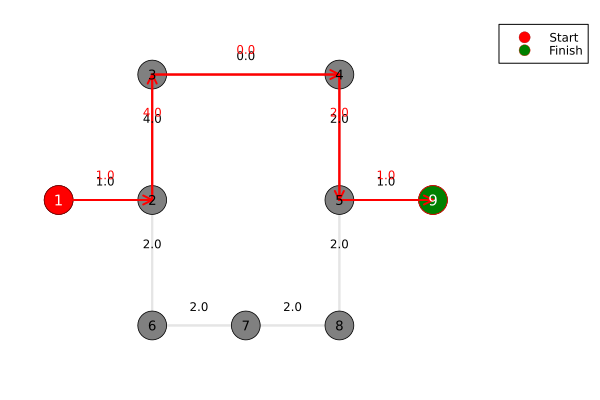

In [ ]:
let

    # initialize -
    base_graphmodel = discounted_graphmodel;
    source_node = 1
    target_node = 9
    shortest_path_nodes = reconstruct_path(p₁,  target_node); # reconstruct the path to the project completion node (9)

    # build set of edges on the shortest path for quick lookup
    path_edges = length(shortest_path_nodes) > 1 ? Set((shortest_path_nodes[i], shortest_path_nodes[i+1]) for i in 1:length(shortest_path_nodes)-1) : Set{Tuple{Int,Int}}()

    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
        # annotate the edge weight slightly above the midpoint unless this edge is on the shortest path
        if !((s,t) in path_edges)
            mx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
            my = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
            w = round(base_graphmodel.edges[(s,t)], digits=2)
            annotate!(mx, my + 0.15, text(string(w), 8, :black))
        end
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:red, 
             label="Finish")

    # plot path -
    for i in 1:length(shortest_path_nodes)-1
        s = shortest_path_nodes[i]
        t = shortest_path_nodes[i+1]
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:red, lw=2, label="")
        # annotate the path-edge weight in red slightly above the red edge
        mwx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        mwy = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        w = round(base_graphmodel.edges[(s,t)], digits=2)
        annotate!(mwx, mwy + 0.20, text(string(w), 8, :red))
    end

    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(8.5, 11.5))

    current()
end

## Summary
In this activity, we successfully applied Dijkstra's algorithm to solve a project planning optimization problem with step costs. The problem demonstrated why __non-negative edge weights__ are crucial for Dijkstra: all project costs were positive (time, money, resources), making it the perfect choice over Bellman-Ford for efficiency.

> __Key insights:__ Our project graph structure made the optimization straightforward because we only had two main competing paths from start to finish. This meant we could manually predict the optimal route and verify Dijkstra found the same solution, building confidence in both our intuition and the algorithm.

> __Algorithm verification:__ Our manual cost analysis predicted which path Dijkstra should choose based on the edge weights. This demonstrates how breaking down simple problems can help us understand and verify complex algorithms before applying them to larger, more challenging scenarios.

__Real-world formulation:__ In practice, project management problems often involve more complex constraints like resource availability, task dependencies, and uncertain costs. While our shortest path approach works well for simple sequential planning, techniques like __Critical Path Method (CPM)__ or __project scheduling algorithms__ would be more appropriate for complex project management with parallel tasks and resource constraints.

__Looking ahead:__ Understanding when and why to choose Dijkstra over Bellman-Ford is crucial for optimization problems. Dijkstra's efficiency with non-negative weights makes it ideal for many real-world applications, but recognizing its limitations helps us choose the right tool for each problem.